# Dataset creation

In [632]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from geopy.distance import geodesic
from tqdm.auto import tqdm
from itertools import combinations
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy

import random

os.environ["PYTHONOPTIMIZE"] = "2"

@dataclass
class City:
    name: str
    lat: float
    lon: float
    
    def __hash__(self):
        return hash(self.name)

@dataclass
class Individual:
    genome: np.ndarray
    fitness: float = None

    def __lt__(self, other):
        return self.fitness < other.fitness
    
    def __init__(self, genome: np.ndarray, fitness: float = None):
        self.genome = genome
        self.fitness = fitness

In [633]:
CITIES = None
DIST_MATRIX = None
EDGES = set()

In [634]:
def load_dist_matrix(country):
    global DIST_MATRIX
    try:
        with open(f'data/dist_matrix_{country}.pkl', 'rb') as f:
            DIST_MATRIX = pickle.load(f)
    except:
        DIST_MATRIX = dict()
        for c1, c2 in combinations(CITIES, 2):
            DIST_MATRIX[(c1, c2)] = DIST_MATRIX[(c2, c1)] = geodesic((c1.lat, c1.lon), (c2.lat, c2.lon)).km
        with open(f'data/dist_matrix_{country}.pkl', 'wb') as f:
            pickle.dump(DIST_MATRIX, f)
            
def load_cities(country):
    global CITIES
    try:
        CITIES = np.load(f'cities/{country}.npy')
    except:
        CITIES = pd.read_csv('cities/'+country+'.csv', header=None, names=['city', 'lat', 'lon'])
        CITIES = [City(row.city, row.lat, row.lon) for row in CITIES.itertuples()]
        np.save(f'cities/{country}.npy', CITIES)

In [635]:
def plot_graph(g, title=None, out_file=None):

    world = gpd.read_file("data/ne_110m_admin_0_countries.zip")
    world.plot(color='lightgray')

    pos = {city: (city.lon, city.lat) for city in CITIES}
    extreme_cities = [
        max(CITIES, key=lambda city: city.lat),  # North
        min(CITIES, key=lambda city: city.lat),  # South
        max(CITIES, key=lambda city: city.lon),  # East
        min(CITIES, key=lambda city: city.lon)   # West
    ]
    min_x = extreme_cities[3].lon
    max_x = extreme_cities[2].lon
    min_y = extreme_cities[1].lat
    max_y = extreme_cities[0].lat

    temp = []
    # Labeling CITIES with their names
    for (city,horizontal,vertical) in zip(extreme_cities,['center', 'center', 'left', 'right'],['bottom', 'top', 'center', 'center']):
        if city not in temp:
            temp.append(city)
            plt.text(city.lon, city.lat, city.name, fontsize=9, ha=horizontal, va=vertical)

    nx.draw(g, pos, with_labels=False, node_size=10, font_size=8, edge_color='black', node_color='red', style='dotted')
    margin_x = 0.2*(max_x - min_x)
    margin_y = 0.2*(max_y - min_y)

    plt.xlim([min_x-margin_x, max_x+margin_x])  
    plt.ylim([min_y-margin_y, max_y+margin_y])
    
    if title:
        plt.title(title)
    if out_file:
        plt.savefig(out_file)
    plt.show()

Average distance: 420.52 km
Median distance: 378.44 km


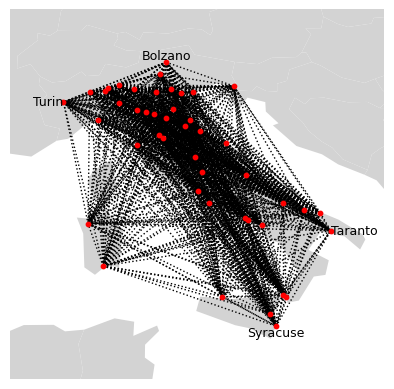

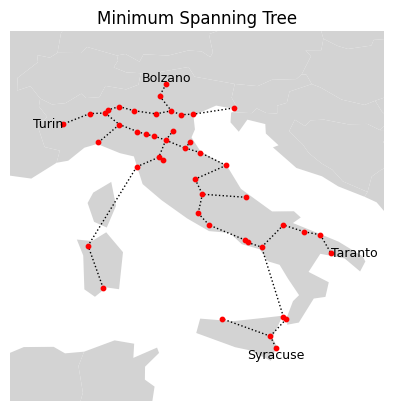

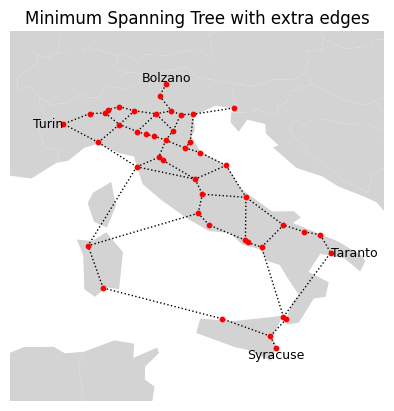

In [636]:
country = 'italy'

load_cities(country)
load_dist_matrix(country)

total_distance = sum(distance for _, distance in DIST_MATRIX.items())
average_distance = total_distance / len(DIST_MATRIX)
print(f'Average distance: {average_distance:.2f} km')

distances = list(DIST_MATRIX.values())
median_distance = np.median(distances)
print(f'Median distance: {median_distance:.2f} km')

g = nx.Graph() 

for (city1, city2), distance in DIST_MATRIX.items():
    g.add_edge(city1, city2, weight=distance)
plot_graph(g)

mst =nx.minimum_spanning_tree(g)
plot_graph(mst, title="Minimum Spanning Tree", out_file="data/mst.png")
for city in sorted(CITIES, key=lambda city: (city.lon, city.lat)):
    distances = [(DIST_MATRIX[(city, c)], c) for c in CITIES if c != city]
    distances.sort()
    for distance, other_city in distances[:10]:
        if nx.shortest_path_length(mst, source=city, target=other_city, weight='weight') > 2*distance:
            mst.add_edge(city, other_city, weight=distance)
plot_graph(mst, title="Minimum Spanning Tree with extra edges", out_file="data/my_solution.png")
